In [1]:
import re
import nltk
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

In [2]:
# Ensure necessary resources are downloaded
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\romaf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\romaf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
df = pd.read_csv("dblp-v10-titles-only.csv")

In [4]:
df = df.head(10000)

In [5]:
from tqdm import tqdm

In [6]:
def token_and_filter_pos_combos(text_corpus):
      
    corpus = []
    for sent in tqdm(text_corpus):

        sent_tokens = []
        
        words = []
        for word,tag in nltk.pos_tag(nltk.word_tokenize(sent)):
            if tag in {"JJ","JJR","JJS","NN","NNS","NNP","NNPS"}:
                words.append(word)
            else:
                if len(words) > 0:
                    sent_tokens.append(" ".join(words))
                words = []
        if len(words) > 0:
                    sent_tokens.append(" ".join(words))
        corpus.append(sent_tokens)
    return(corpus)

In [7]:
terms = token_and_filter_pos_combos(df['title'].to_list())

100%|██████████| 10000/10000 [00:08<00:00, 1243.81it/s]


In [8]:
import math
from collections import Counter

def compute_tf_icf(sentence_terms):
    # Flatten list of terms for TF computation
    flattened_terms = [term for sentence in sentence_terms for term in sentence]
    term_counts = Counter(flattened_terms)
    
    # Total number of terms
    total_terms = len(flattened_terms)
    
    # Compute TF for each term
    tf = {term: count / total_terms for term, count in term_counts.items()}
    
    # Compute ICF for each term
    total_sentences = len(sentence_terms)
    term_in_sentences = Counter(term for sentence in sentence_terms for term in set(sentence))
    icf = {term: math.log(total_sentences / (1 + count)) for term, count in term_in_sentences.items()}
    
    # Compute TF-ICF
    tf_icf = {term: tf[term] * icf[term] for term in tf.keys()}
    
    return tf_icf

In [9]:
tf_icf_scores = compute_tf_icf(terms)

In [10]:
# Step 3: Train Word2Vec embedding
model = Word2Vec(sentences=terms, vector_size=50)

In [11]:
# Extract embeddings
words = [x for x in list(model.wv.key_to_index.keys()) if tf_icf_scores[x] >= 0.001]
embeddings = [model.wv[word] for word in words]

# Step 4: Perform UMAP dimensionality reduction
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [12]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_scaled)

c:\Users\romaf\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
from sklearn.cluster import KMeans
import numpy as np

# Example points in 2D space (replace with your points)
points = np.array(embeddings_scaled.tolist())

# Number of clusters (choose based on your data or use a method like the elbow method to find the optimal number)
kmeans = KMeans(n_clusters=8)
kmeans.fit(points)

kclasses = kmeans.predict(embeddings_scaled.tolist())


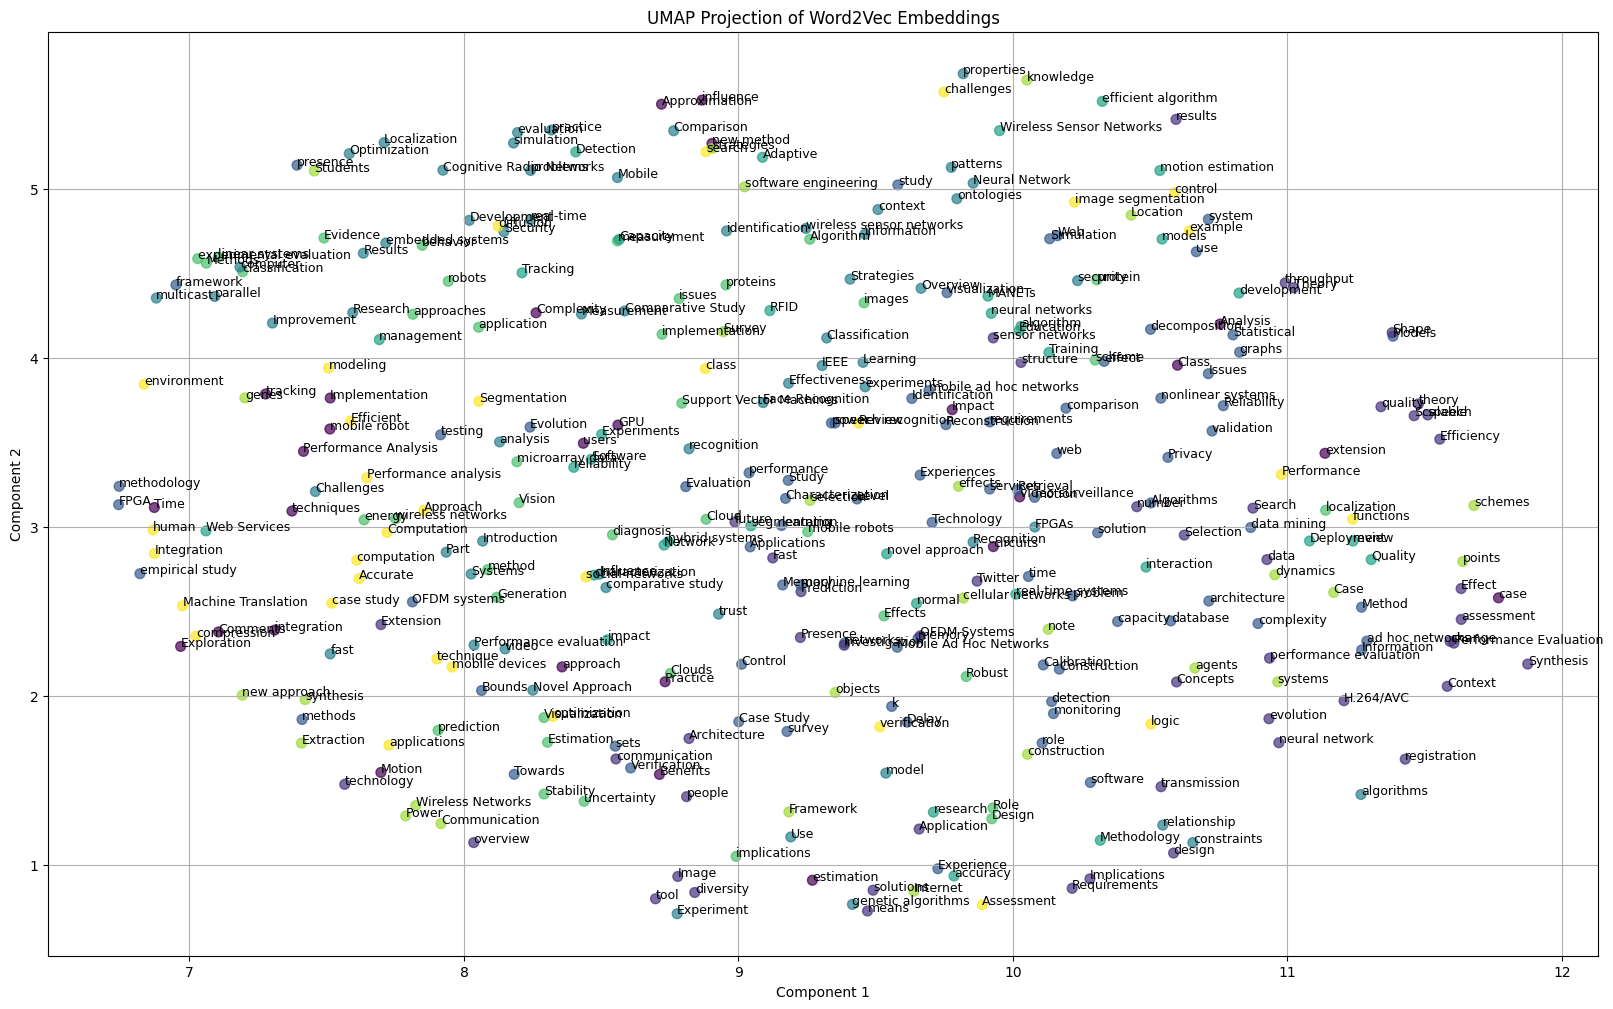

In [14]:
# Step 5: Visualize results
plt.figure(figsize=(20, 12))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c =kclasses , s=50, alpha=0.7)

for i, word in enumerate(words):
    plt.text(umap_embeddings[i, 0], umap_embeddings[i, 1], word, fontsize=9)

plt.title("UMAP Projection of Word2Vec Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [15]:
import numpy as np
from collections import Counter

class KNNWithProximity:
    def __init__(self, k=3, max_distance=None):
        """
        Initialize the k-NN classifier with proximity filtering.

        Parameters:
            k (int): Number of neighbors to consider.
            max_distance (float): Maximum distance threshold for making predictions.
        """
        self.k = k
        self.max_distance = max_distance
        self.points = None
        self.labels = None

    def fit(self, points, labels):
        """
        Fit the model with training data.

        Parameters:
            points (array-like): Training points, shape (n_samples, n_features).
            labels (array-like): Class labels for training points, shape (n_samples,).
        """
        self.points = np.array(points)
        self.labels = np.array(labels)

    def predict(self, new_points):
        """
        Predict the class for new points.

        Parameters:
            new_points (array-like): Points to predict, shape (m_samples, n_features).

        Returns:
            list: Predicted classes or None for points outside the proximity threshold.
        """
        new_points = np.array(new_points)
        predictions = []

        for point in new_points:
            distances = np.linalg.norm(self.points - point, axis=1)
            
            # Get indices of k nearest neighbors
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_distances = distances[nearest_indices]

            # Check if the nearest neighbor is within max_distance
            if self.max_distance is not None and np.all(nearest_distances > self.max_distance):
                predictions.append(None)
            else:
                nearest_labels = self.labels[nearest_indices]
                most_common_label = Counter(nearest_labels).most_common(1)[0][0]
                predictions.append(most_common_label)

        return predictions

In [16]:
h3_hex_knn = KNNWithProximity(k=2, max_distance=0.2)
h3_hex_knn.fit(umap_embeddings,kclasses)

In [17]:
words_emb = []
for w,e,k in zip(words,umap_embeddings,kclasses):
    e = e.tolist()
    e.reverse()
    words_emb.append({"words":w,"coord": e,'class':k})

words_emb

[{'words': 'Design',
  'coord': [1.270948886871338, 9.923389434814453],
  'class': 5},
 {'words': 'application',
  'coord': [4.1825408935546875, 8.053583145141602],
  'class': 5},
 {'words': 'Application',
  'coord': [1.210173487663269, 9.658439636230469],
  'class': 1},
 {'words': 'Analysis',
  'coord': [4.201991558074951, 10.755282402038574],
  'class': 0},
 {'words': 'systems',
  'coord': [2.0818777084350586, 10.964851379394531],
  'class': 6},
 {'words': 'analysis',
  'coord': [3.5033390522003174, 8.130006790161133],
  'class': 3},
 {'words': 'Wireless Sensor Networks',
  'coord': [5.347448825836182, 9.9514799118042],
  'class': 4},
 {'words': 'Performance',
  'coord': [3.3103888034820557, 10.978330612182617],
  'class': 7},
 {'words': 'design',
  'coord': [1.068171739578247, 10.585430145263672],
  'class': 1},
 {'words': 'Evaluation',
  'coord': [3.23848819732666, 8.808167457580566],
  'class': 2},
 {'words': 'applications',
  'coord': [1.7068824768066406, 7.726461887359619],
  'c

In [18]:
colors = [(230, 25, 75),
 (60, 180, 75),
 (255, 225, 25),
 (67, 99, 216),
 (245, 130, 49),
 (145, 30, 180),
 (66, 212, 244),
 (240, 50, 230),
 (191, 239, 69),
 (250, 190, 212),
 (70, 153, 144),
 (220, 190, 255),
 (154, 99, 36),
 (255, 250, 200),
 (128, 0, 0),
 (170, 255, 195),
 (128, 128, 0),
 (255, 216, 177),
 (0, 0, 117),
 (169, 169, 169),
 (0, 0, 0),]

In [19]:
def gen_hexes(x1,x2,y1,y2,resolution,number_of_samp = 100,):
    hexes = []
    for x in np.linspace(x1,x2,number_of_samp):
        for y in np.linspace(y1,y2,number_of_samp):
            hexes.append(h3.latlng_to_cell(x,y,resolution))
    return list(set(hexes))

In [20]:
def gen_surround(points,resolution):
    all_hexes = set()
    for x,y in points:
        all_hexes.update(gen_hexes(x-1,x+1,y-1,y+1,resolution))

    return list(all_hexes)

In [21]:
import numpy as np
import h3
RESOLUTON = 6

In [22]:
dummy_hexes = gen_surround(umap_embeddings,RESOLUTON)

In [ ]:
h3_hex_classes = h3_hex_knn.predict([ h3.cell_to_latlng(x) for x in dummy_hexes])

[None,
 None,
 2,
 3,
 None,
 None,
 None,
 0,
 1,
 None,
 None,
 None,
 3,
 3,
 None,
 None,
 1,
 7,
 None,
 None,
 None,
 None,
 None,
 2,
 1,
 None,
 None,
 None,
 None,
 2,
 None,
 1,
 None,
 4,
 2,
 2,
 5,
 None,
 3,
 7,
 None,
 None,
 None,
 None,
 None,
 1,
 2,
 3,
 None,
 2,
 2,
 1,
 None,
 1,
 None,
 None,
 None,
 6,
 None,
 4,
 6,
 None,
 None,
 1,
 None,
 None,
 4,
 None,
 None,
 3,
 1,
 None,
 2,
 None,
 None,
 3,
 None,
 None,
 None,
 None,
 6,
 0,
 None,
 6,
 6,
 None,
 2,
 1,
 1,
 1,
 3,
 None,
 3,
 7,
 1,
 None,
 None,
 3,
 2,
 None,
 6,
 None,
 6,
 None,
 None,
 0,
 None,
 None,
 3,
 3,
 1,
 None,
 None,
 4,
 None,
 3,
 None,
 None,
 None,
 None,
 None,
 2,
 3,
 1,
 3,
 None,
 1,
 7,
 None,
 None,
 1,
 None,
 6,
 3,
 None,
 None,
 7,
 None,
 None,
 2,
 4,
 None,
 None,
 6,
 4,
 None,
 None,
 None,
 6,
 3,
 None,
 5,
 None,
 None,
 1,
 1,
 5,
 1,
 4,
 None,
 None,
 1,
 5,
 None,
 None,
 2,
 None,
 None,
 3,
 5,
 None,
 None,
 None,
 0,
 None,
 None,
 None,
 3,
 None,
 N

In [24]:
parsed_dict = {}
for c in colors:
    parsed_dict[c] = []
parsed_dict[(255,255,255)] = [] # for Empty hexes

for h3_h,hex_class in zip(dummy_hexes,h3_hex_classes):
    if hex_class is None:
        parsed_dict[(255,255,255)].append(h3_h)
    else:
        parsed_dict[colors[hex_class]].append(h3_h)

In [25]:
data = []
for i,v in parsed_dict.items():
    if len(v) > 0:
        data.append({"color":i,'hexIds':v})

In [50]:
import json

words_emb_json = [ {
    'words': x['words'],               
    'coord': [ float(y) for y in x['coord']],
    'class': int(x['class']),
    'tf_icf': tf_icf_scores[x['words']],
    }for x in words_emb]

with open('words_emb.json','w') as f:
    json.dump(words_emb_json,f)

In [52]:

with open('hex_data.json','w') as f:
    json.dump(data,f)

In [27]:
words_emb1 = [{'words': x['words'], 'coord' : x['coord']} for x in words_emb]

In [28]:
import pydeck as pdk

from pydeck.types import String

layer = pdk.Layer(
    "H3ClusterLayer",
    data,
    # pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagons="hexIds",
    get_fill_color="color",
    get_line_color=[255, 255, 255],
    line_width_min_pixels=1,
    opacity=0.1,
)
layer2 = pdk.Layer(
    "TextLayer",
    words_emb1,
    pickable=True,
    get_position="coord",
    get_text="words",
    get_size=13,
    opacity=0.8,
    get_color=[255,255,255],
    get_angle=0,
    # Note that string constants in pydeck are explicitly passed as strings
    # This distinguishes them from columns in a data set
    get_text_anchor=String("middle"),
    get_alignment_baseline=String("center"),
)


# Set the viewport location
view_state = pdk.ViewState(
    longitude=23,
    latitude=14,
    zoom=5,
    min_zoom=1,
    max_zoom=15,
    pitch=0,
    bearing=0)



In [39]:
# Combined all of it and render a viewport
from ipywidgets import HTML

text = HTML(value='Move the viewport')

def callback(widget_instance, payload):
    text.value = 1


r = pdk.Deck(layers=[layer,layer2], initial_view_state=view_state,map_provider="None")
r.deck_widget.on_click(callback)
display(text)
r.show()
r.to_html('hexagon-example.html')

HTML(value='Move the viewport')